## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
#from pyemma import msm
%matplotlib inline

In [2]:
# set max columns to none
pd.set_option("display.max_rows", None)

## Importing data

In [3]:
df = pd.read_csv("sample_labeled_data.csv")
df.head()

,Model Name,Column Name,Transaction Value (Count or Avg),Transcation Month (YYYY|MM),IsAnAnomaly,Snapshot Month (YYYYMM)
0,TABLE_1,Column_756,428838.84,2016|02,NO,202104
1,TABLE_1,Column_756,569641.20,2016|03,NO,202104
2,TABLE_1,Column_756,446080.47,2016|04,NO,202104
3,TABLE_1,Column_756,498157.66,2016|05,NO,202104
4,TABLE_1,Column_756,521634.10,2016|06,NO,202104


## Formating data

In [4]:
# Changing column name
df.columns = ['Model_name', 'Column_name', 'Transaction_value', 'Month_transaction', 'IsAnAnomaly', 'Snapshot_month']

In [5]:
df.Month_transaction = pd.to_datetime(df.Month_transaction, format='%Y|%m') # Converting to datetime datatype
df.sort_values(by = ["Month_transaction"], inplace=True) # Sorting data by transaction date
df.reset_index(drop = True, inplace=True) # resetting index 
#df.set_index('Month_transaction', inplace=True)
df.drop(['Model_name'], inplace = True, axis = 1) # Dropping Model_name feature as it has single value throughout
df.head()

,Column_name,Transaction_value,Month_transaction,IsAnAnomaly,Snapshot_month
0,Column_826,0.00000,2015-09-01,NaN,202011
1,Column_826,0.00000,2015-10-01,NaN,202012
2,Column_1688,0.00000,2015-10-01,NaN,202012
3,Column_1752,65.03375,2015-10-01,NaN,202012
4,Column_826,0.00000,2015-10-01,NaN,202011


## Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2745 entries, 0 to 2744
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Column_name        2745 non-null   object        
 1   Transaction_value  2745 non-null   float64       
 2   Month_transaction  2745 non-null   datetime64[ns]
 3   IsAnAnomaly        915 non-null    object        
 4   Snapshot_month     2745 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 107.4+ KB


In [7]:
#calculating Transaction value at each percentile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = df['Transaction_value'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 95.92269
50 percentile value is 164930.189
60 percentile value is 528349.7
70 percentile value is 2212371.25
80 percentile value is 3317993.2
90 percentile value is 9469238.0
100 percentile value is  39643768.0


In [8]:
#calculating Transaction value at each percentile 91, 92, 93, 94, 95, 96, 97, 98, 99, 100 
for i in range(91,100,1):
    var = df['Transaction_value'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

91 percentile value is 9837552.0
92 percentile value is 10237712.0
93 percentile value is 10944481.0
94 percentile value is 25519428.0
95 percentile value is 27183112.0
96 percentile value is 28997184.0
97 percentile value is 30666708.0
98 percentile value is 33292184.0
99 percentile value is 35375656.0
100 percentile value is  39643768.0


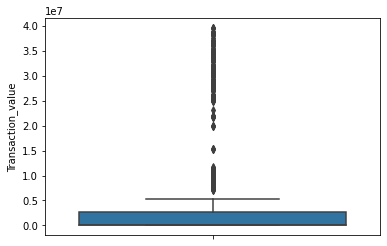

In [9]:
# ploting box-plot
sn.boxplot(y='Transaction_value', data = df)
plt.show()


<h5>
### From the above analysis we can see there is lot of missing data in IsAnAnomaly feature <br>
### Also there are lot of outliers present in the data <br>
### However, I'm not removing outlier in this case as it is leading to huge data loss <br>
    </h5>

In [10]:
df.columns

Index(['Column_name', 'Transaction_value', 'Month_transaction', 'IsAnAnomaly',
       'Snapshot_month'],
      dtype='object')

## Time Series splitting

In [11]:
# Testing dataset (latest snapshot)
test_data = df[df.Snapshot_month == 202104]
ts_test = test_data.Transaction_value


# Training dataset
train_data = df[df.Snapshot_month != 202104]
ts_train = train_data.Transaction_value

In [12]:
test_data.head()

,Column_name,Transaction_value,Month_transaction,IsAnAnomaly,Snapshot_month
82,Column_1815,0.0,2016-02-01,NO,202104
84,Column_1574,8693291.0,2016-02-01,YES,202104
102,Column_1040,3518558.0,2016-02-01,YES,202104
111,Column_1599,0.0,2016-02-01,NO,202104
112,Column_802,392577.8,2016-02-01,NO,202104


In [13]:
train_data.head()

,Column_name,Transaction_value,Month_transaction,IsAnAnomaly,Snapshot_month
0,Column_826,0.00000,2015-09-01,NaN,202011
1,Column_826,0.00000,2015-10-01,NaN,202012
2,Column_1688,0.00000,2015-10-01,NaN,202012
3,Column_1752,65.03375,2015-10-01,NaN,202012
4,Column_826,0.00000,2015-10-01,NaN,202011


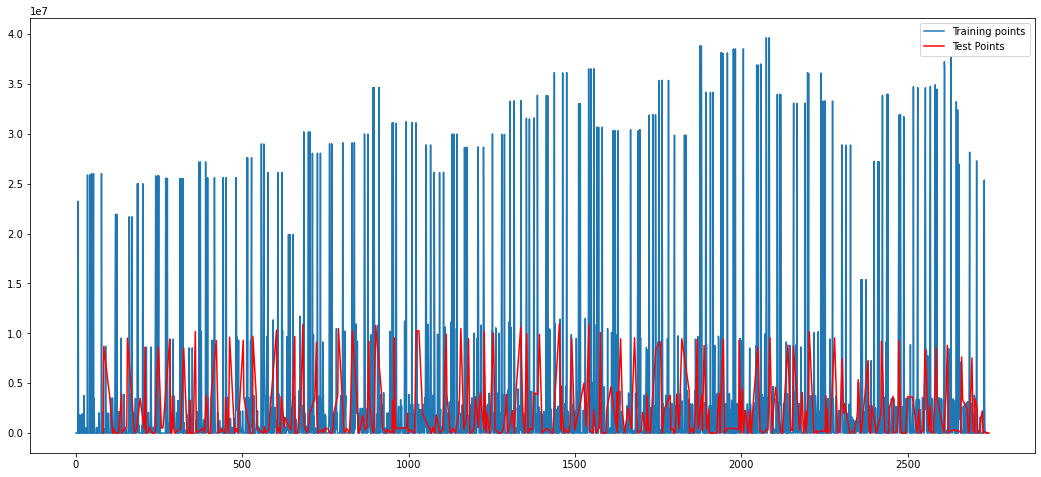

In [14]:
# Plotting Transaction_value of training and testing set

plt.figure(figsize = (18,8))
train_data.Transaction_value.plot(label = "Training points")
test_data.Transaction_value.plot(color = "red", label = "Test Points")
plt.legend()
plt.show()

## Check Stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

def check_stationarity(ts):
    dftest = adfuller(ts)
    print(dftest)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
        print("p-Value is: ", pvalue)
    else:
        print('The series is NOT stationary')

In [16]:
check_stationarity(ts_train)

(-14.067843426767096, 2.9766507896587086e-26, 19, 2298, {'1%': -3.4331988336181656, '5%': -2.8627985509372906, '10%': -2.567439983623706}, 79464.05635250967)
The series is stationary
p-Value is:  2.9766507896587086e-26


In [17]:
# I transform it, by differencing once and I check again for stationarity.

ts_diff = ts_train.diff()
ts_diff.dropna(inplace=True)
check_stationarity(ts_diff)

(-16.776684563376996, 1.2739870830045112e-29, 27, 2289, {'1%': -3.433210047397854, '5%': -2.862803502559176, '10%': -2.5674426199971334}, 79557.78032147592)
The series is stationary
p-Value is:  1.2739870830045112e-29


In [18]:
# Now, the time series is stationary, thus I can set the difference order for the training model to 1.

d = 1

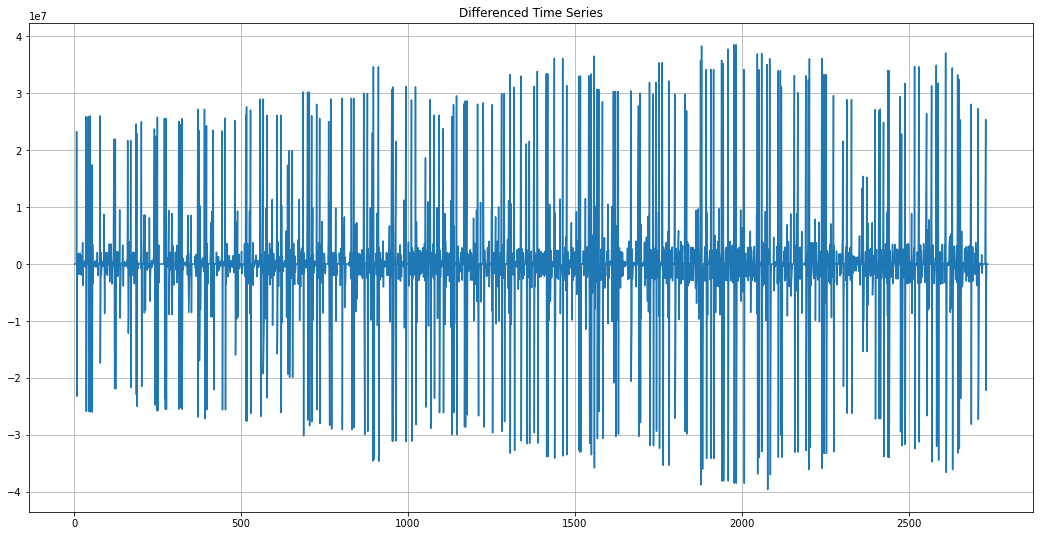

In [19]:
# Plotting the differenced time series

plt.figure(figsize = (18, 9))
plt.plot(ts_diff)
plt.title('Differenced Time Series')
plt.grid()
plt.show()

In [20]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plot_pacf(ts_diff, lags =15)
#plt.show()

In [21]:
#p = 2

In [22]:
#plot_acf(ts_diff, lags =100)
#plt.show()

In [23]:
#q = 1

In [24]:
#train_data = train_data.reset_index()
#test_data = test_data.reset_index()

In [25]:
train_data.head()

,Column_name,Transaction_value,Month_transaction,IsAnAnomaly,Snapshot_month
0,Column_826,0.00000,2015-09-01,NaN,202011
1,Column_826,0.00000,2015-10-01,NaN,202012
2,Column_1688,0.00000,2015-10-01,NaN,202012
3,Column_1752,65.03375,2015-10-01,NaN,202012
4,Column_826,0.00000,2015-10-01,NaN,202011


In [26]:
# Dropping IsAnAnomaly feature from the training dataset
# I will be treating this as a unsupervised learning problem
# Another reason is there are lot of missing values present for this feature

train_data.drop(['IsAnAnomaly'], axis = 1, inplace = True)
train_data.head()

,Column_name,Transaction_value,Month_transaction,Snapshot_month
0,Column_826,0.00000,2015-09-01,202011
1,Column_826,0.00000,2015-10-01,202012
2,Column_1688,0.00000,2015-10-01,202012
3,Column_1752,65.03375,2015-10-01,202012
4,Column_826,0.00000,2015-10-01,202011


In [27]:
# I have not dropped IsAnAnomaly feature in case of test datset as I'll need this for validation
# Replacing IsAnAnomaly value "YES" with 1 and "NO" with 0

test_data.IsAnAnomaly = test_data.IsAnAnomaly.map({'YES': 1, 'NO': 0})

In [28]:
train_data.head()

,Column_name,Transaction_value,Month_transaction,Snapshot_month
0,Column_826,0.00000,2015-09-01,202011
1,Column_826,0.00000,2015-10-01,202012
2,Column_1688,0.00000,2015-10-01,202012
3,Column_1752,65.03375,2015-10-01,202012
4,Column_826,0.00000,2015-10-01,202011


In [29]:
test_data.head()

,Column_name,Transaction_value,Month_transaction,IsAnAnomaly,Snapshot_month
82,Column_1815,0.0,2016-02-01,0,202104
84,Column_1574,8693291.0,2016-02-01,1,202104
102,Column_1040,3518558.0,2016-02-01,1,202104
111,Column_1599,0.0,2016-02-01,0,202104
112,Column_802,392577.8,2016-02-01,0,202104


In [30]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sn.light_palette("blue")
    plt.subplot(1, 3, 1)
    sn.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sn.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sn.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Modeling

In [48]:
data = train_data[['Transaction_value']]  
scaler = StandardScaler() # Scaling function to standardized the range of data 
data = scaler.fit_transform(data)  # fitting and tranforming scaling function on the data

# Training Isolation forest model
model =  IsolationForest(n_estimators = 210, n_jobs = -1, random_state = 42)  # 
model.fit(data)

IsolationForest(n_estimators=210, n_jobs=-1, random_state=42)

In [49]:
# Anomaly Prediction on training data

pred_train = pd.Series(model.predict(data))
train_data['pred_anomaly'] = pred_train

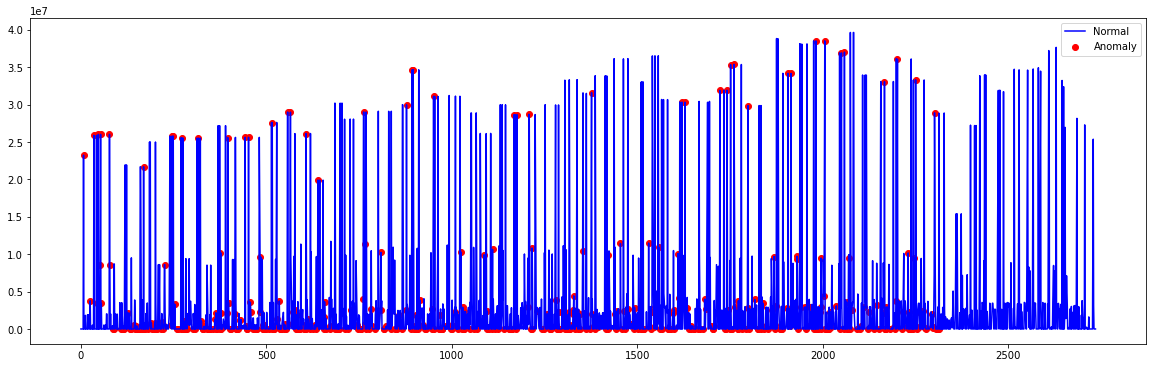

In [50]:
# Visualizing anomaly points on training data

fig, ax = plt.subplots(figsize=(20,6))

a = train_data[train_data['pred_anomaly'] == -1] #anomaly

ax.plot(train_data.index, train_data['Transaction_value'], color='blue', label = 'Normal')
ax.scatter(a.index,a['Transaction_value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

## Testing

In [51]:
test = test_data[['Transaction_value']]
test = scaler.transform(test) # Transforming test set

In [52]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427 entries, 82 to 2744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Column_name        427 non-null    object        
 1   Transaction_value  427 non-null    float64       
 2   Month_transaction  427 non-null    datetime64[ns]
 3   IsAnAnomaly        427 non-null    int64         
 4   Snapshot_month     427 non-null    int64         
 5   prediction         427 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 23.4+ KB


In [53]:
test_data['prediction'] = model.predict(test) # Prediction on test data

In [54]:
# Replacing 1 (on anomaly) with 0 and -1 (is anomaly) with 1

test_data.prediction = test_data.prediction.map( {1: 0, -1: 1}) 

In [55]:
# Classification report

from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix
print(classification_report(test_data['IsAnAnomaly'].values, test_data.prediction))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       305
           1       0.76      0.92      0.83       122

    accuracy                           0.89       427
   macro avg       0.86      0.90      0.88       427
weighted avg       0.90      0.89      0.90       427



In [56]:
confusion_matrix(test_data['IsAnAnomaly'].values, test_data.prediction)

array([[269,  36],
       [ 10, 112]], dtype=int64)

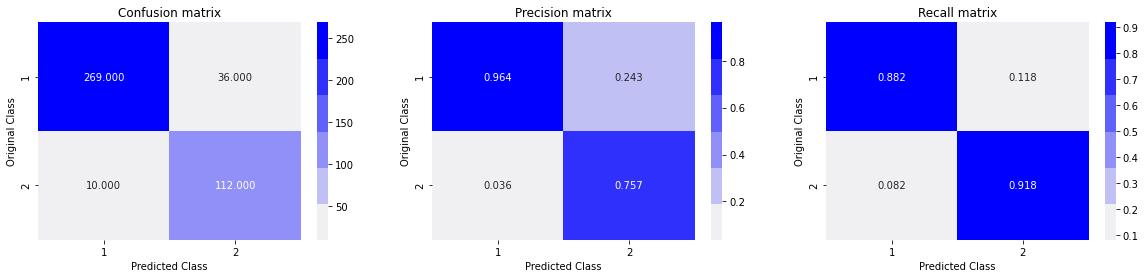

In [57]:
plot_confusion_matrix(test_data['IsAnAnomaly'].values, test_data.prediction)

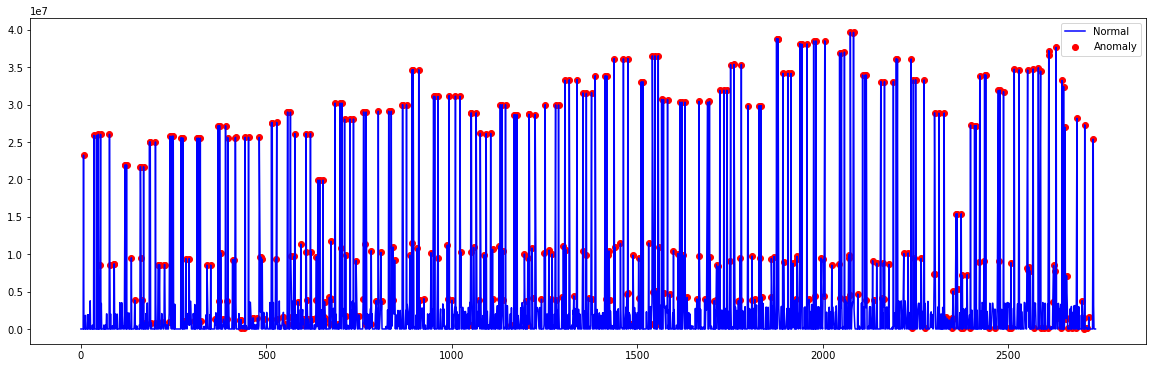

In [58]:
data = train_data[['Transaction_value']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(n_estimators = 230, contamination=0.2, random_state = 42)
model.fit(data)

train_data['pred_anomaly'] = model.predict(data)
# df['anomaly2'] = df['anomaly2'].map( {1: 0, -1: 1} )

fig, ax = plt.subplots(figsize=(20,6))

a = train_data[train_data['pred_anomaly'] == -1] #anomaly

ax.plot(train_data.index, train_data['Transaction_value'], color='blue', label = 'Normal')
ax.scatter(a.index,a['Transaction_value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [59]:
test_data['prediction'] = model.predict(test)
test_data.prediction = test_data.prediction.map( {1: 0, -1: 1})
print(classification_report(test_data['IsAnAnomaly'].values, test_data.prediction))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       305
           1       0.80      0.81      0.80       122

    accuracy                           0.89       427
   macro avg       0.86      0.86      0.86       427
weighted avg       0.89      0.89      0.89       427



In [60]:
confusion_matrix(test_data['IsAnAnomaly'].values, test_data.prediction)

array([[280,  25],
       [ 23,  99]], dtype=int64)

In [61]:
precision_score(test_data['IsAnAnomaly'].values, test_data.prediction)

0.7983870967741935

In [62]:
recall_score(test_data['IsAnAnomaly'].values, test_data.prediction)

0.8114754098360656

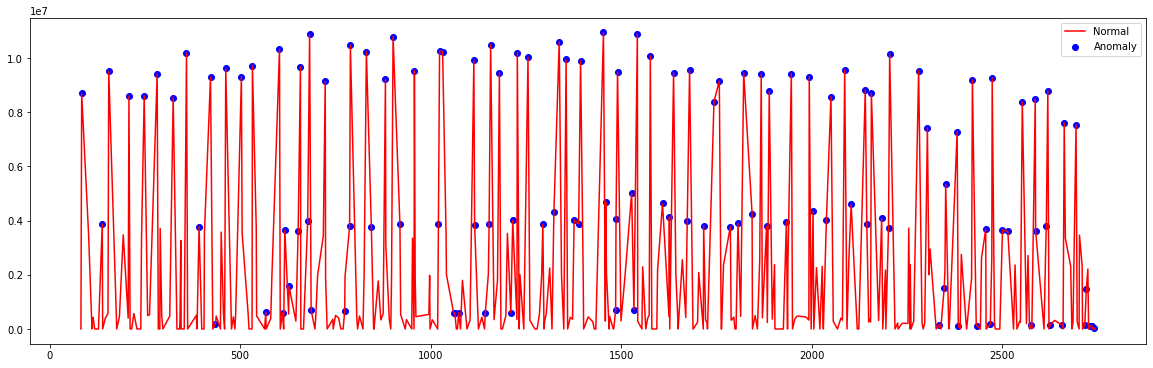

In [63]:
fig, ax = plt.subplots(figsize=(20,6))

a = test_data[test_data['prediction'] == 1] #anomaly

#ax.plot(train_data['index'], train_data['Transaction_value'], color='blue', label = 'Normal')
ax.plot(test_data.index, test_data['Transaction_value'], color='red', label = 'Normal')
ax.scatter(a.index,a['Transaction_value'], color='blue', label = 'Anomaly')
plt.legend()
plt.show();

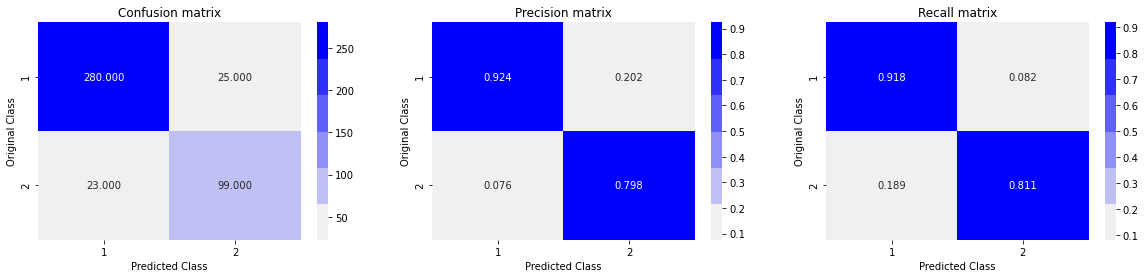

In [64]:
plot_confusion_matrix(test_data['IsAnAnomaly'].values, test_data.prediction)